Overall Accuracy:  0.8669227961696473
                       precision    recall  f1-score   support

                Urban       0.62      0.14      0.22     18280
             Cropland       0.89      0.92      0.90    258671
                Trees       0.88      0.91      0.89     46869
                Water       0.98      0.99      0.98     40781
              Wetland       0.72      0.76      0.74     21928
            Shrubland       0.79      0.73      0.76    127738
            Grassland       0.87      0.90      0.89    433910
               Barren       0.86      0.78      0.82     35020
Irrigated_Agriculture       0.42      0.07      0.12       420

             accuracy                           0.87    983617
            macro avg       0.78      0.69      0.70    983617
         weighted avg       0.86      0.87      0.86    983617



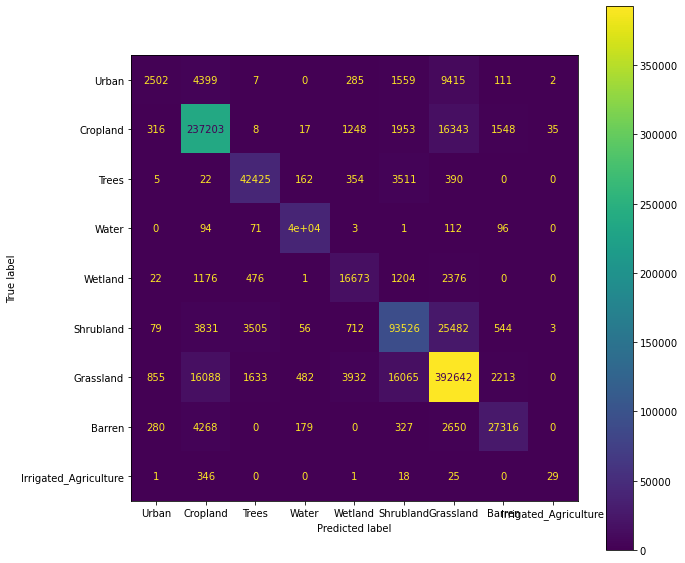

In [23]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from rasterio.enums import Resampling
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

# classification files and class dictionary: change them based on your data
ref_map='C:/Users/lliu/Desktop/FrontierSI/projects/FAO/working/GEE_Lesotho_newest/RF_lesotho_2021.tif' # reference classification map
pred_map='C:/Users/lliu/Desktop/FrontierSI/projects/FAO/working/GEE_Lesotho_newest/Land_cover_prediction_Lesotho_2021_GEE_replicate_sampling_mosiac_AOI.tif'# predicted classification map
dict_map={1:'Urban',2:'Cropland',4:'Trees',6:'Water',7:'Wetland',9:'Shrubland',10:'Grassland',12:'Barren',14:'Irrigated_Agriculture'}

# load maps
landcover_ref=xr.open_dataarray(ref_map,engine="rasterio").astype(np.uint8)
landcover_pred=xr.open_dataarray(pred_map,engine="rasterio").astype(np.uint8)
# landcover_ref=xr.open_dataset(ref_map,engine="rasterio",decode_coords="all").astype(np.uint8).squeeze() 
# landcover_pred=xr.open_dataset(pred_map,engine="rasterio",decode_coords="all").astype(np.uint8).squeeze()

# reproject to align maps
landcover_pred=landcover_pred.rio.reproject_match(landcover_ref,resampling=Resampling.nearest)

# convert to numpy arrays
n_compare_samples=len(landcover_ref['x'])*len(landcover_ref['y'])
np_landcover_ref=landcover_ref.to_numpy().reshape((n_compare_samples,))
np_landcover_pred=landcover_pred.to_numpy().reshape((n_compare_samples,))

# exclude invalid values (e.g. 0, 255) for comparison
invalid_mask=(np_landcover_ref==0)|(np_landcover_pred==0)|(np_landcover_ref==255)|(np_landcover_pred==255)
np_landcover_ref=np_landcover_ref[~invalid_mask]
np_landcover_pred=np_landcover_pred[~invalid_mask]

# calculate and display confusion matrix and OA
overall_acc=accuracy_score(np_landcover_ref,np_landcover_pred)
print('Overall Accuracy: ',overall_acc)
cm=confusion_matrix(np_landcover_ref, np_landcover_pred)
display_labels=[dict_map[np.unique(np_landcover_ref)[i]] for i in range(len(dict_map))]
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

# calculate and display per-class scores
print(classification_report(np_landcover_ref,np_landcover_pred,target_names=display_labels))